__Proyecto__: Predicción de temperatura en el distribuidor de Colada continua <br>
__Fecha de inicio__: 13 noviembre 2021 <br>
__Fecha ultima actualizacion__: 15 agosto 2022 <br>
__Desarrollo__: Aracely Mtz <br>

# Objective

Mejoras al modelo de caída de temperatura versión 1 ya implementado

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import math
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
from sklearn.utils.fixes import parse_version
import pickle 

In [2]:
plt.rcParams.update({'font.size': 12})

## Clases y definiciones

In [3]:
sys.path.append("../../../")
from utils.utils import PlotHistBoxplot, PlotPredictionRes,outliersIQR, PlotMissingBar, GraficasResultados

# Leer datos 

In [4]:
pwd

'/home/emorenor/Acerias-Celaya/Caída de Temperatura/notebooks/Prediccion_TemperaturaHA'

* Correr las secciones 1-3, 6 y 8 del notebook 1.1 Análisis de muestras de temperatura. Cargar únicamente datos de temperatura. Esto genera los datos de caída de temperatura. Ignorar las secciones 4, 5 y 7.
* Correr el notebook 1.2 para crear los arcvhivos de entrada para este, ignorar las secciones 5 y 6.

In [5]:
# Leer datos 
root = f"../../data/data_modelo/THA_finales/"
# version = 

In [6]:
# Revisamos los archivos que estan en el directorio
for file in os.listdir(root):
    print(file)

THA_dataset_H2.csv
THA_dataset.csv


In [7]:
# Dataset que se genera en los notebooks exploratorios
# Ruta del archivo donde se genera el dataset
#"GitHub\Acerias-Celaya\Caída de Temperatura\notebooks\2.A Análisis Exploratorio y Limpieza de información CT_raw H1.ipynb"

dataset = pd.read_csv(f"{root}THA_dataset.csv",index_col = "cla_colada")
dataset.head(3)

,TUNDISH_HEAT_COUNTER,LADLE_LIFE,LADLE_TOTAL_WEIGHT_RS,LADLE_EMPTY_TIME,LADLE_FULL_TIME_CURRENT,CASTING_TIME,TRANSFER_TIME_RS_CCM,t_liquidus,cla_horno,nom_grado,SH_promedio,first_afino,mean_temp_colada,last_afino
cla_colada,,,,,,,,,,,,,,
189462,29,24.0,112.64226,80.333333,7.633333,35.0,12.116633,1466.99827,2,1078 CG,28.50173,1512,1495.50,1525
189466,4,2.0,115.60653,30.783333,6.600000,48.0,13.333367,1528.51518,2,1004 CEL,23.68482,1558,1552.20,1605
189467,5,26.0,118.57080,22.750000,7.800000,40.0,13.333300,1528.22774,2,1004 CEL,31.02226,1539,1559.25,1597


# Configuración de variables

In [8]:
dataset.columns

Index(['TUNDISH_HEAT_COUNTER', 'LADLE_LIFE', 'LADLE_TOTAL_WEIGHT_RS',
       'LADLE_EMPTY_TIME', 'LADLE_FULL_TIME_CURRENT', 'CASTING_TIME',
       'TRANSFER_TIME_RS_CCM', 't_liquidus', 'cla_horno', 'nom_grado',
       'SH_promedio', 'first_afino', 'mean_temp_colada', 'last_afino'],
      dtype='object')

In [9]:
data_H1 = dataset[dataset["cla_horno"] == 2] #Horno 1
data_H2 = dataset[dataset["cla_horno"] == 3] #Horno 2

data_H1.drop("cla_horno", axis = 1, inplace = True)
data_H2.drop("cla_horno", axis = 1, inplace = True)

/opt/jupyterhub/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [10]:
data_H1.shape, data_H2.shape

((950, 13), (4320, 13))

In [11]:
# Definir variables depedientes e independientes
tar = "last_afino"
variables = ['TUNDISH_HEAT_COUNTER', 'LADLE_LIFE', 'LADLE_TOTAL_WEIGHT_RS',
       'LADLE_EMPTY_TIME', 'LADLE_FULL_TIME_CURRENT', 'CASTING_TIME',
       'TRANSFER_TIME_RS_CCM', 't_liquidus','first_afino',
       'mean_temp_colada']

# Preparación de datos

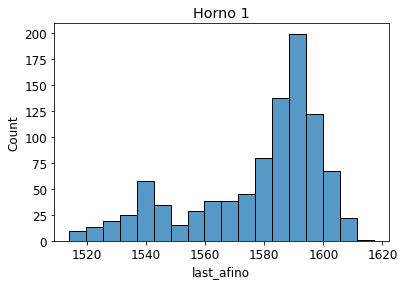

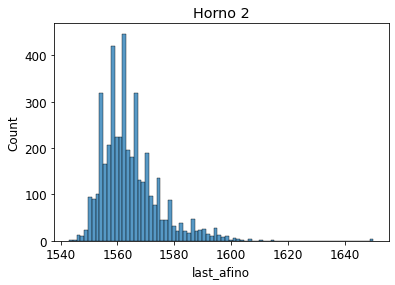

In [12]:
# Horno 1

sns.histplot(data_H1[tar])
plt.title("Horno 1")
plt.show()

sns.histplot(data_H2[tar])
plt.title("Horno 2")
plt.show()

# Análisis de importancia de variables

In [13]:
horno = 1
data = data_H1.copy()

In [14]:
data.isna().sum()

TUNDISH_HEAT_COUNTER       0
LADLE_LIFE                 0
LADLE_TOTAL_WEIGHT_RS      0
LADLE_EMPTY_TIME           0
LADLE_FULL_TIME_CURRENT    0
CASTING_TIME               0
TRANSFER_TIME_RS_CCM       0
t_liquidus                 0
nom_grado                  0
SH_promedio                0
first_afino                0
mean_temp_colada           0
last_afino                 0
dtype: int64

In [15]:
data.dropna(inplace = True)

In [16]:
corr = data.corr()

/tmp/ipykernel_321285/1931227312.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


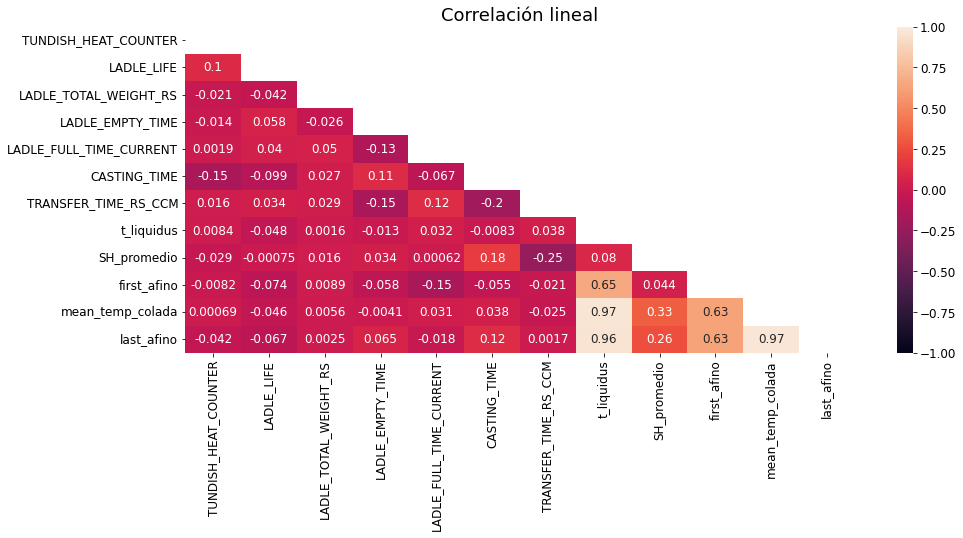

In [17]:
plt.figure(figsize=(15, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(corr, dtype=np.bool))
heatmap = sns.heatmap(corr, mask=mask,vmin=-1, vmax=1,annot=True)
heatmap.set_title('Correlación lineal', fontdict={'fontsize':18});

In [18]:
class feature_importance_method:
    def __init__(self, dataframe, tar="caida_temp", prc_split = 0.33, thr = None, n_features = None):    
        self.df = dataframe
        self.tar = tar
        self.prc = prc_split
        self.thr = thr
        self.n_features = n_features
    
    def TrainTest_split(self):
        # Definir variables depedientes e independientes
        self.X = self.df.drop(columns = self.tar)
        self.y = self.df[self.tar]
        
        # Train Test Split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y,
                                                            test_size = self.prc, 
                                                            random_state = 42)
    
    def Permutation_method(self):
        self.TrainTest_split()
        
        # Crear instancia de Random Forest Regressor
        reg = RandomForestRegressor(random_state=0)
        # Fit a random forest regressor
        reg.fit(self.X_train, self.y_train)
        #Prediccion
        y_pred = reg.predict(self.X_test)
        self.y_pred = pd.DataFrame(y_pred, index = self.y_test.index)
        
        rmse_full_mod = mean_squared_error(self.y_pred, self.y_test, squared = False)
        # Permutacion
        results = []
        # Iterar cada columna
        for col in self.X_test.columns:
            # Creamos una copia
            X_test_copy = self.X_test.copy()

            # Sufflear cada columna
            X_test_copy[col] = self.X_test[col].sample(frac=1).values

            # Calcular el RMSE
            new_rmse = mean_squared_error(reg.predict(X_test_copy), self.y_test,
                                          squared = False)

            # Agregar a la lista de resultados
            results.append({'pred': col,
                            'score': new_rmse - rmse_full_mod })
        # Convert to a pandas dataframe and rank the predictors by score
        self.resultsdf = pd.DataFrame(results).sort_values(by = 'score',
                                                      ascending = False)
        self.reg = reg
        print("Procedmimiento exitoso")
        
    def Variance_method(self):
        self.TrainTest_split()
        
        # Crear instancia de Random Forest Regressor y Selector
        reg = RandomForestRegressor(random_state=0)
        selector = VarianceThreshold(threshold= self.thr)
        
        X_train_varthr = selector.fit_transform(self.X_train)
        X_test_varthr = selector.transform(self.X_test)
        
        reg.fit(X_train_varthr, self.y_train)
        
        #Predicción sobre test
        y_pred = reg.predict(X_test_varthr)
        self.y_pred = pd.DataFrame(y_pred, index = self.y_test.index)
        self.selected_variables = list(self.X_train.columns[selector.get_support()])
        self.reg = reg
        print("Procedmimiento exitoso")
    
    def RandomSelect_method(self):
        self.TrainTest_split()
        
        # Crear instancia de Random Forest Regressor y Selector
        reg = RandomForestRegressor(random_state=0)
        
        selector = RFE(reg, n_features_to_select = self.n_features, step=1)
        selector = selector.fit(self.X_train, self.y_train)
        
        #Predicción sobre test
        self.y_pred = selector.predict(self.X_test)
#         self.y_pred = pd.DataFrame(y_pred, index = self.y_test.index)
        self.selected_variables = list(self.X_train.columns[selector.get_support()])
        
        self.reg = selector
        print("Procedmimiento exitoso")

In [19]:
## Permutación de características

# Crear instancia de la clase para métodos de Feature importance
FIM = feature_importance_method(data[variables + [tar]], tar = "last_afino")

# Instanciar el método de Permutación de características
FIM.Permutation_method()

Procedmimiento exitoso


In [20]:
# Imprimir resultados del score
FIM.resultsdf.head(30).reset_index(drop =True)

,pred,score
0,mean_temp_colada,25.773102
1,t_liquidus,1.790385
2,CASTING_TIME,0.637208
3,TUNDISH_HEAT_COUNTER,0.187632
4,LADLE_EMPTY_TIME,0.166390
5,TRANSFER_TIME_RS_CCM,0.116499
6,LADLE_FULL_TIME_CURRENT,0.033225
7,LADLE_TOTAL_WEIGHT_RS,-0.013870
8,LADLE_LIFE,-0.023567
9,first_afino,-0.033017


Text(0.5, 1.0, 'Set de prueba: Método Permutación')

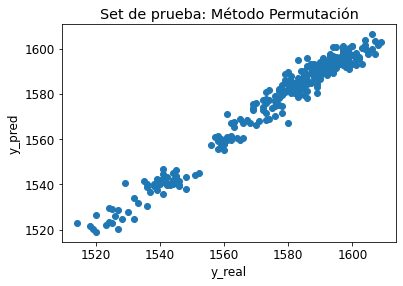

In [21]:
# Graficar los resultados de test y predict
plt.scatter(FIM.y_test, FIM.y_pred)
plt.xlabel("y_real")
plt.ylabel("y_pred")
plt.title("Set de prueba: Método Permutación")

# Train-Test split

In [22]:
# Definir variables depedientes e independientes

X = data[variables]
y = data[tar]

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.33, 
                                                    random_state = 42)

# Pruebas Modelo

In [23]:
# Definir Pipeline para escalamiento y modelo

parameters = {'depth': [4,5,6,7,8],
                 'learning_rate' : [0.01,0.05,0.02,0.3, 0.5],
                  'iterations': [300,400,500]
                 }

RFparameters = {'max_depth': [4,5,6,7,8],
                'learning_rate' : [0.01,0.05,0.02,0.3, 0.5],
                'n_estimators': [300,400,500]
               }

GBFparameters = {
    "n_estimators": [300,400,500],
    "max_depth": [4,5,6,7,8],
    "learning_rate": [0.01,0.05,0.02,0.3, 0.5]
}


models_dict = {"LinealSimple" : LinearRegression(),
               "LRidge" : RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]),
               "GradientBR": RandomizedSearchCV(GradientBoostingRegressor(random_state = 0), 
                                                   param_distributions = GBFparameters, cv = 5, n_iter = 20, random_state = 0),
               
               
              # "catboost": CatBoostRegressor(silent = True, random_state = 0),
              # "RGridCatboost": RandomizedSearchCV(CatBoostRegressor(silent = True, random_state = 0), 
              #                                     param_distributions = parameters, scoring = ["explained_variance", "r2", "neg_mean_absolute_percentage_error", "neg_mean_absolute_error"],
              #                                     refit = "neg_mean_absolute_percentage_error", cv = 5, n_iter = 30, random_state = 0),
               "RGridForest": RandomForestRegressor(n_estimators=300,max_depth=7,random_state = 0)
              }

scaler_dict = {"Quantile": QuantileTransformer(n_quantiles=3, random_state=42), 
               "Sscaler": StandardScaler(),
               "MinMax": MinMaxScaler(),
               "None": None
              }

## Iteraciones de algoritmos

In [24]:
# def metricas(yreal, ypred, umbral = 5):    
#     # Cálculos
#     residuals = yreal - ypred # Error
#     std = np.std(residuals) #Desviación estándar
#     mae = mean_squared_error(yreal, ypred)
#     abserror = abs(residuals)
#     prc = 100*(abserror < umbral).sum()/len(abserror)
#     print("Testing: Error promedio = %.2f" % np.average(residuals))
#     print("Testing: Desviación estándar del error = %.2f" % std)
#     print("Testing: MSE = %.2f" % mae)
#     print("Porcentaje de coladas con un error <= %u °C: %.2f" %(umbral, prc))
    
def metricas(yreal, ypred, umbral = 5): 
    # Cálculos
    residuals = yreal - ypred # Error
    std = np.std(residuals) #Desviación estándar
    mae = mean_squared_error(yreal, ypred)
    abserror = abs(residuals)
    prc = 100*(abserror < umbral).sum()/len(abserror)
    
    df = pd.DataFrame({"Error promedio": np.average(residuals),
                        "std": std,
                        "MAE": mae,
                        f"% Error <{umbral}": prc}, index = [0]
                     )
    
    return df

In [25]:
# df_metricas = pd.DataFrame()
# for key_model in ["LRidge", "LinealSimple", "catboost", "RGridCatboost", "RGridForest", "GradientBR"]:
#     for key_scale in ["Quantile", "MinMax"]:
#         pipe = Pipeline([('scaler', scaler_dict[key_scale]),
#                         ("model", models_dict[key_model])])

#         # Entrenamiento
#         pipe.fit(X_train, y_train)

#         # Vector de predicciones
#         y_pred = pipe.predict(X_test)

    
#         df = metricas(y_test, y_pred)
#         df = (df.assign(Scale = key_scale)).assign(Modelo = key_model)
#         df_metricas = df_metricas.append(df)
#     print(f"{key_model} Listo......")

In [26]:
# df_metricas

In [27]:
horno

1

In [28]:
# # Guardar resultados de las iteraciones para seleccionar el mejor
# df_metricas.to_csv(f"../../docs/15. Sprint Resultados/Metricas_horno{horno}.csv")

In [29]:
# # Modelo elegido

# key_model = "RGridCatboost"
# key_scale =  "MinMax"
# pipe = Pipeline([('scaler', scaler_dict[key_scale]),
#                 ("model", models_dict[key_model])])

# # Entrenamiento
# pipe.fit(X_train, y_train)

# # Vector de predicciones
# y_pred = pipe.predict(X_test)

# print(f"{key_model} Listo......")

In [30]:
horno

1

In [31]:
# ## Guardar modelo como pickle

# import pickle 

# version = "v.0"

# with open(f"../../pickles/Prediccion_HA/Temperatura_salida_HA{horno}_{version}.pickle", "wb") as file:
#     pickle.dump(pipe, file)

# Cargar modelo

In [32]:
# Abrir modelo
horno = 2 # 1 o 2
version = "v.0"
with open(f"../../pickles/Prediccion_HA/Temperatura_salida_HA{horno}_{version}.pickle", "rb") as file:
    model = pickle.load(file)

In [33]:
data_RW = pd.read_csv("data/CT_totales.csv")

In [34]:
data_RW.head(1)

,cla_colada,fecha_administrativa,cla_horno,num_tratamiento,hay_distri,hay_empalme,cla_distribuidor,tons_pq_buena,fhr_ini,fhr_fin,...,lquim_f5,fecha_inicio_vaciado,fecha_fin_vaciado,min_duracion_vaciado,tiempo_contacto,Temp_SHeat,Temp_SHeat_Min,Temp_SHeat_Max,tipo_colada,t_liquidus
0,123200,2021-03-30 00:00:00,3,1.0,0.0,1.0,26.0,100.78518,2021-03-29 19:36:33,2021-03-29 20:32:48,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,secuencia,1503.92396


In [35]:
# Elegir dataset
data = data_H2.copy()

# Definir variables depedientes e independientes
X = data[variables]
y = data[tar]

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.33, 
                                                    random_state = 42)

In [36]:
X_train.shape, X_test.shape

((2894, 10), (1426, 10))

In [37]:
y_pred = model.predict(X_test)

In [39]:
# # Horno1
# dfImp = pd.DataFrame({"name": X_train.columns,
# "imp":  model.named_steps["model"].coef_})
# Horno 2
dfImp = pd.DataFrame({"name": X_train.columns,
"imp": model.named_steps["model"].best_estimator_.feature_importances_})

dfImp = dfImp.sort_values("imp", ascending = True)

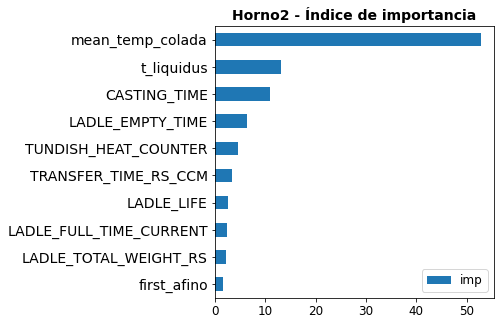

In [40]:
dfImp.set_index("name").plot.barh(figsize = (5,5))
plt.ylabel("")
plt.title(f"Horno{horno} - Índice de importancia", fontsize=14, fontweight = "bold")
plt.yticks(fontsize=14)
plt.show()

In [41]:
# Instancia de modelo
results = GraficasResultados(y_test.values, y_pred, key_model, umbral=5, size=(5,5))

results.diagnostic_plots()

NameError: name 'key_model' is not defined

In [42]:
residuals = abs(y_test - y_pred)
residuals_ok = residuals[residuals <= 5]

# Simulación ONline

In [43]:
# Elegir dataset
data = data_H2.copy()

<AxesSubplot:xlabel='CASTING_TIME', ylabel='Count'>

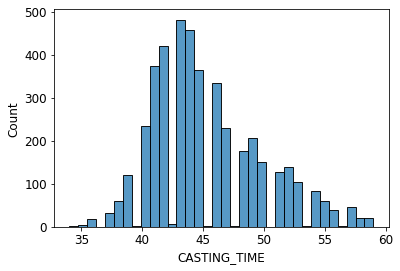

In [44]:
sns.histplot(data["CASTING_TIME"])

In [45]:
data.head(3)

,TUNDISH_HEAT_COUNTER,LADLE_LIFE,LADLE_TOTAL_WEIGHT_RS,LADLE_EMPTY_TIME,LADLE_FULL_TIME_CURRENT,CASTING_TIME,TRANSFER_TIME_RS_CCM,t_liquidus,nom_grado,SH_promedio,first_afino,mean_temp_colada,last_afino
cla_colada,,,,,,,,,,,,,
125224,26,50.0,151.17777,97.550000,23.866667,54.0,9.566633,1524.17945,1008 BCO,28.82055,1532,1553.0,1593
125225,27,23.0,115.60653,90.266667,18.216667,53.0,13.666667,1526.28432,1006 VDE CEL,29.71568,1597,1556.0,1595
125226,28,93.0,127.46361,72.866667,22.416667,46.0,13.499967,1526.70591,1006 VDE CEL,30.29409,1567,1557.0,1599


In [46]:
# Variable Casting time la cambiamos por el esperado

data["CASTING_TIME"] = data["CASTING_TIME"].shift()
mean_value = data["CASTING_TIME"].mean()

data["CASTING_TIME"].fillna(value=mean_value, inplace=True)

In [47]:
# Variable Casting time
data.loc[:,"mean_temp_colada"] = data.loc[:,"t_liquidus"] + 25

In [48]:
data

,TUNDISH_HEAT_COUNTER,LADLE_LIFE,LADLE_TOTAL_WEIGHT_RS,LADLE_EMPTY_TIME,LADLE_FULL_TIME_CURRENT,CASTING_TIME,TRANSFER_TIME_RS_CCM,t_liquidus,nom_grado,SH_promedio,first_afino,mean_temp_colada,last_afino
cla_colada,,,,,,,,,,,,,
125224,26,50.0,151.17777,97.550000,23.866667,45.32298,9.566633,1524.17945,1008 BCO,28.820550,1532,1549.17945,1593
125225,27,23.0,115.60653,90.266667,18.216667,54.00000,13.666667,1526.28432,1006 VDE CEL,29.715680,1597,1551.28432,1595
125226,28,93.0,127.46361,72.866667,22.416667,53.00000,13.499967,1526.70591,1006 VDE CEL,30.294090,1567,1551.70591,1599
125227,29,70.0,139.32069,77.200000,20.600000,46.00000,10.366700,1527.39169,1006 VDE CEL,26.608310,1606,1552.39169,1596
125228,30,51.0,130.42788,73.833333,18.933333,55.00000,12.900033,1526.72332,1006 VDE CEL,24.876680,1634,1551.72332,1596
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135548,23,48.0,135.93690,100.183333,12.966667,53.00000,11.766700,1497.64464,1036-10 QTB,35.855360,1510,1522.64464,1577
135549,24,79.0,138.89205,101.816667,13.216667,50.00000,15.299967,1495.58959,1036-10 QTB,37.910410,1546,1520.58959,1572
135550,25,2.0,132.98175,102.583333,10.083333,53.00000,11.933333,1496.90370,1036-10 QTB,31.262967,1538,1521.90370,1570


In [49]:
# Definir variables depedientes e independientes

X = data[variables]
y = data[tar]

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.33, 
                                                    random_state = 42)

In [50]:
X_train.shape, X_test.shape

((2894, 10), (1426, 10))

In [51]:
X_test.head(3)

,TUNDISH_HEAT_COUNTER,LADLE_LIFE,LADLE_TOTAL_WEIGHT_RS,LADLE_EMPTY_TIME,LADLE_FULL_TIME_CURRENT,CASTING_TIME,TRANSFER_TIME_RS_CCM,t_liquidus,first_afino,mean_temp_colada
cla_colada,,,,,,,,,,
126221,13,58.0,138.57057,64.983333,19.966667,44.0,17.083300,1499.10717,1554,1524.10717
125478,28,79.0,141.51888,49.983333,10.416667,41.0,9.583300,1503.52721,1544,1528.52721
130116,42,62.0,141.51888,57.716667,16.766667,42.0,17.699967,1497.98557,1545,1522.98557


In [52]:
y_pred = model.predict(X_test)

## Graficar resultados

In [53]:
# Instancia de modelo
results = GraficasResultados(y_test.values, y_pred, key_model, umbral=5)

results.diagnostic_plots()

NameError: name 'key_model' is not defined

# Gráficas para comparar

In [54]:
df_temp = pd.read_csv("data/CT_caida_temp.csv")

In [55]:
df_temp.head()

,cla_colada,first_afino,fhr_muestra_first_afino,last_afino,fhr_muestra_last_afino,first_colada,fhr_muestra_first_mcc,last_colada,fhr_muestra_last_mcc,mean_temp_colada,std_temp_colada,max_colada,min_colada,SH_promedio,SH_std,SH_min,SH_max,cla_horno
0,123200,1550,2021-03-29 20:48:27,1568,2021-03-29 20:56:01,1521,2021-03-29 21:16:31,1530,2021-03-29 21:50:56,1526.714286,3.251373,1530,1521,22.790326,3.251373,17.07604,26.07604,3
1,123201,1557,2021-03-29 21:38:01,1574,2021-03-29 21:48:55,1534,2021-03-29 22:02:43,1525,2021-03-29 22:44:08,1526.800000,4.266146,1534,1523,17.968430,4.266146,14.16843,25.16843,3
2,123202,1534,2021-03-29 22:24:10,1581,2021-03-29 22:40:59,1533,2021-03-29 22:57:12,1530,2021-03-29 23:45:12,1534.333333,5.131601,1540,1530,31.382013,5.131601,27.04868,37.04868,3
3,123203,1555,2021-03-29 23:05:31,1574,2021-03-29 23:33:38,1534,2021-03-29 23:55:11,1538,2021-03-30 00:20:33,1536.000000,2.828427,1538,1534,32.557170,2.828427,30.55717,34.55717,3
4,123204,1526,2021-03-29 23:58:22,1577,2021-03-30 00:24:50,1535,2021-03-30 00:45:59,1529,2021-03-30 01:12:35,1532.000000,4.242641,1535,1529,28.231830,4.242641,25.23183,31.23183,3


In [56]:
resultados_pred = pd.DataFrame(y_test).assign(y_pred = y_pred)
resultados_pred.rename(columns = {"last_afino": "y_real"}, inplace = True)

In [57]:
resultados_pred = resultados_pred.join(df_temp.set_index("cla_colada")["SH_promedio"])

In [58]:
resultados_pred.head()

,y_real,y_pred,SH_promedio
cla_colada,,,
126221,1562,1557.219019,30.226163
125478,1568,1561.181757,30.472790
130116,1560,1555.792394,26.514430
130732,1560,1562.430894,24.725900
125557,1563,1561.602958,28.513170


In [59]:
# Elegimos las coladas con un error de predicción dentro de +/- 5°C

resultados_pred = resultados_pred.loc[residuals_ok.index]

resultados_pred.describe()

,y_real,y_pred,SH_promedio
count,1133.000000,1133.000000,1133.000000
mean,1563.681377,1561.180681,28.813019
std,8.427302,7.471945,5.246928
min,1548.000000,1549.584349,13.150850
25%,1558.000000,1556.429733,25.395460
50%,1562.000000,1558.940881,28.676527
75%,1567.000000,1563.623189,32.017820
max,1599.000000,1594.718626,48.519113


In [60]:
yreal = resultados_pred["y_real"]
ypred = resultados_pred["y_pred"]


In [61]:
sh_real = resultados_pred["SH_promedio"]
df_SH = pd.DataFrame(sh_real)
df_SH.head(2)
df_SH["control"] = 0
inf_sh = (df_SH["SH_promedio"] < 20).sum() * 100/df_SH.shape[0]
sup_sh = (df_SH["SH_promedio"] > 30).sum()  * 100/df_SH.shape[0]
control_sh = ((df_SH["SH_promedio"] >= 20)&(df_SH["SH_promedio"] <= 30)).sum()* 100/df_SH.shape[0]
df_SH.loc[df_SH["SH_promedio"] < 20, "control"] = 1
df_SH.loc[df_SH["SH_promedio"] > 30, "control"] = 2
f"{control_sh: .2f}"
df_SH = df_SH.join(data_RW.set_index("cla_colada")["fecha_administrativa"])
dict_colors = {0: "mediumblue", 1: "gray", 2: "orangered"}
df_SH["control"] = df_SH["control"].map(dict_colors)

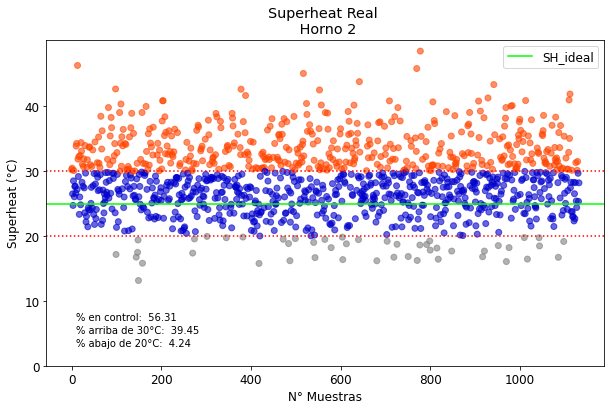

In [62]:
plt.figure(figsize = (10,6))
plt.scatter(x = np.arange(len(sh_real)), y = df_SH["SH_promedio"], c = df_SH["control"], alpha = 0.6)
plt.axhline(y = 25, color = 'lime', label = "SH_ideal")
plt.axhline(y = 30, color = 'r', linestyle = "dotted")
plt.axhline(y = 20, color = 'r', linestyle = "dotted")
plt.ylabel("Superheat (°C)")
plt.xlabel("N° Muestras")
plt.title(f"""Superheat Real \n Horno {horno}""")
plt.yticks(np.arange(0, max(sh_real)+1, 10))
plt.text(10, 7, f"% en control: {control_sh: .2f}", fontsize = 10)
plt.text(10, 5, f"% arriba de 30°C: {sup_sh: .2f}", fontsize = 10)
plt.text(10, 3, f"% abajo de 20°C: {inf_sh: .2f}", fontsize = 10)
plt.legend()
plt.show()

In [63]:
residual = yreal-ypred
error_sh = sh_real -residual #error de superheat

In [64]:
residual.describe()

count    1133.000000
mean        2.500696
std         4.825893
min       -11.937474
25%        -0.818575
50%         2.069440
75%         5.576914
max        19.757791
dtype: float64

In [65]:
#EMR 
#Mismo proceso que en la construcción de Super Heat real
resultados_pred_newsh=resultados_pred.copy()
resultados_pred_newsh['SH_Simulado']=error_sh
resultados_pred_newsh
error_sh=resultados_pred_newsh['SH_Simulado']

df_SHSIM = pd.DataFrame(error_sh)
df_SHSIM["control"] = 0

inf_sh = (df_SHSIM["SH_Simulado"] < 20).sum() * 100/df_SHSIM.shape[0]
sup_sh = (df_SHSIM["SH_Simulado"] > 30).sum()  * 100/df_SHSIM.shape[0]
control_sh = ((df_SHSIM["SH_Simulado"] >= 20)&(df_SHSIM["SH_Simulado"] <= 30)).sum()* 100/df_SHSIM.shape[0]
df_SHSIM.loc[df_SHSIM["SH_Simulado"] < 20, "control"] = 1
df_SHSIM.loc[df_SHSIM["SH_Simulado"] > 30, "control"] = 2

f"{control_sh: .2f}"
df_SHSIM = df_SHSIM.join(data_RW.set_index("cla_colada")["fecha_administrativa"])
dict_colors = {0: "mediumblue", 1: "gray", 2: "orangered"}
df_SHSIM["control"] = df_SHSIM["control"].map(dict_colors)
df_SHSIM.head()

,SH_Simulado,control,fecha_administrativa
cla_colada,,,
126221,25.445183,mediumblue,2021-07-23 00:00:00
125478,23.654547,mediumblue,2021-06-25 00:00:00
130116,22.306824,mediumblue,2022-01-06 00:00:00
130732,27.156794,mediumblue,2022-01-29 00:00:00
125557,27.116128,mediumblue,2021-06-28 00:00:00


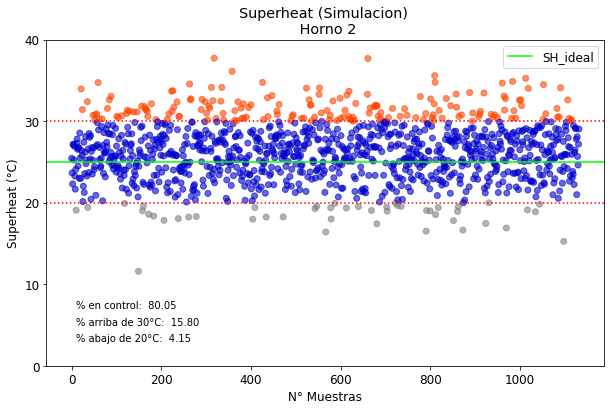

<Figure size 432x288 with 0 Axes>

In [66]:
#EMR #Super Heat Simulado
plt.figure(figsize = (10,6))
plt.scatter(x = np.arange(len(error_sh)), y = df_SHSIM["SH_Simulado"], c = df_SHSIM["control"], alpha = 0.6)
plt.axhline(y = 25, color = 'lime', label = "SH_ideal")
plt.axhline(y = 30, color = 'r', linestyle = "dotted")
plt.axhline(y = 20, color = 'r', linestyle = "dotted")
plt.ylabel("Superheat (°C)")
plt.xlabel("N° Muestras")
plt.title(f"""Superheat (Simulacion) \n Horno {horno}""")
plt.yticks(np.arange(0, max(sh_real)+1, 10))
plt.text(10, 7, f"% en control: {control_sh: .2f}", fontsize = 10)
plt.text(10, 5, f"% arriba de 30°C: {sup_sh: .2f}", fontsize = 10)
plt.text(10, 3, f"% abajo de 20°C: {inf_sh: .2f}", fontsize = 10)
plt.legend()
plt.show()
plt.savefig('SHsimulado_.png', bbox_inches='tight')
#Guardar grafica de dispersion de Super Heat (SH) "Simulado" en los rangos de control 20°C < SH < 30°C, SH>30°C y SH<20°C

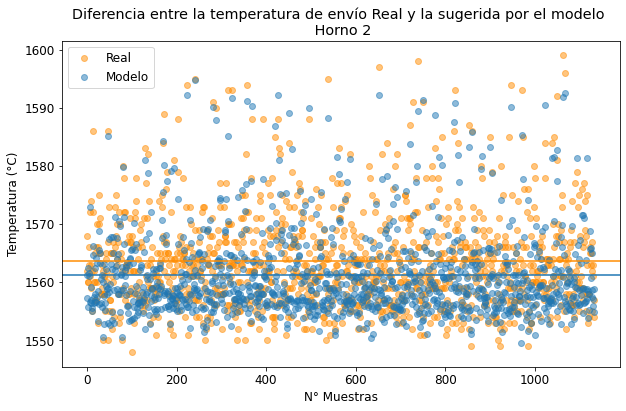

In [70]:
plt.figure(figsize = (10,6))
plt.scatter(x = np.arange(len(yreal)), y = yreal, label = "Real", alpha = 0.5, c = "darkorange")
plt.scatter(x = np.arange(len(ypred)), y = ypred, label = "Modelo", alpha = 0.5)
plt.axhline(y = yreal.mean(), color = 'darkorange')
plt.axhline(y = ypred.mean())

plt.ylabel("Temperatura (°C)")
plt.xlabel("N° Muestras")
plt.title(f"""Diferencia entre la temperatura de envío Real y la sugerida por el modelo \n Horno {horno}""")

# plt.text(0, 10, s1, fontsize = 10)
# plt.text(0, 7, s2, fontsize = 10)
plt.legend()
plt.show()

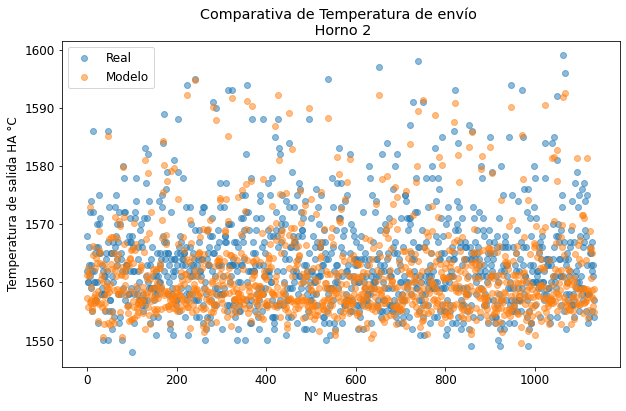

In [71]:
plt.figure(figsize = (10,6))
plt.scatter(x = np.arange(len(yreal)), y = yreal, label = "Real", alpha = 0.5)
plt.scatter(x = np.arange(len(ypred)), y = ypred, label = "Modelo", alpha = 0.5)

plt.ylabel("Temperatura de salida HA °C")
plt.xlabel("N° Muestras")
plt.title(f"""Comparativa de Temperatura de envío \n Horno {horno}""")

plt.legend()
plt.show()